In [7]:
import os
import pandas as pd
import sys
sys.path.append("../src")
import localmodule


# Define constants.
dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_trials = 10


# Loop over augmentations.
# for aug_kind_str in ["all", "none"]:
aug_kind_str = "all"
model_name = "icassp-convnet"
if not aug_kind_str == "none":
    model_name = "_".join([model_name, "aug-" + aug_kind_str])
model_dir = os.path.join(models_dir, model_name)


# Loop over test units.
for test_unit_str in ["unit01"]:#units:
    test_unit_dir = os.path.join(model_dir, test_unit_str)

    # Loop over trials.
    for trial_id in [5]:#range(n_trials):
        trial_str = "trial-" + str(trial_id)
        trial_dir = os.path.join(test_unit_dir, trial_str)
        metrics_dir = os.path.join(trial_dir, "metrics")
        metrics_name = "_".join(
            [dataset_name, model_name,
             test_unit_str, "full-audio-metrics.csv"])
        metrics_path = os.path.join(metrics_dir, metrics_name)
        try:
            x = pd.read_csv(metrics_path)
            print(trial_id, max(x["F1 Score (%)"]))
        except:
            pass
               
    print("")

5 5.427443



In [8]:
x

,Dataset,Augmentation kind,Test unit,Trial,Prediction unit,Tolerance,Threshold,Relevant,Selected,True positives,False positives,False negatives,Precision (%),Recall (%),F1 Score (%)
0,BirdVox-70k,all,unit01,5,unit10,500,1.000000,2936,4835,189,4646,2747,3.908997,6.437330,4.864239
1,BirdVox-70k,all,unit01,5,unit10,500,1.000000,2936,4835,189,4646,2747,3.908997,6.437330,4.864239
2,BirdVox-70k,all,unit01,5,unit10,500,1.000000,2936,4835,189,4646,2747,3.908997,6.437330,4.864239
3,BirdVox-70k,all,unit01,5,unit10,500,1.000000,2936,4835,189,4646,2747,3.908997,6.437330,4.864239
4,BirdVox-70k,all,unit01,5,unit10,500,1.000000,2936,4835,189,4646,2747,3.908997,6.437330,4.864239
5,BirdVox-70k,all,unit01,5,unit10,500,1.000000,2936,4835,189,4646,2747,3.908997,6.437330,4.864239
6,BirdVox-70k,all,unit01,5,unit10,500,1.000000,2936,4835,189,4646,2747,3.908997,6.437330,4.864239
7,BirdVox-70k,all,unit01,5,unit10,500,1.000000,2936,4835,189,4646,2747,3.908997,6.437330,4.864239
8,BirdVox-70k,all,unit01,5,unit10,500,1.000000,2936,4835,189,4646,2747,3.908997,6.437330,4.864239
9,BirdVox-70k,all,unit01,5,unit10,500,1.000000,2936,4835,189,4646,2747,3.908997,6.437330,4.864239


In [3]:
import mir_eval
import numpy as np
import os
import pandas as pd
import peakutils
import scipy.ndimage.filters
import scipy.signal
import sys
sys.path.append('../src')
import localmodule


# Define constants.
data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
#trials = [1, 1, 1, 1, 1, 1]
trials = [5, 7, 9, 7, 7, 8] # maximize clip-wise val acc
icassp_thresholds = 1.0 - np.logspace(-9, 0, 181)
n_thresholds = len(icassp_thresholds)
tolerance = 0.5 # in seconds


# Define directory for model.
aug_str = "all"
model_name = "icassp-convnet"
if not aug_str == "none":
    model_name = "_".join([model_name, "aug-" + aug_str])
model_dir = os.path.join(models_dir, model_name)


# Define directory for annotations.
annotations_name = "_".join([dataset_name, "annotations"])
annotations_dir = os.path.join(data_dir, annotations_name)


tp_matrix = np.zeros((n_thresholds, n_units))
fp_matrix = np.zeros((n_thresholds, n_units))
fn_matrix = np.zeros((n_thresholds, n_units))


#kernel_sizes = [1, 3, 5, 7]
#min_dists = [0, 2, 3, 4, 5, 6, 7, 8]
kernel_sizes = [1]
min_dists = [3]


P_matrix = np.zeros((len(kernel_sizes), len(min_dists), n_thresholds+2))
R_matrix = np.zeros((len(kernel_sizes), len(min_dists), n_thresholds+2))
F_matrix = np.zeros((len(kernel_sizes), len(min_dists), n_thresholds+2))


# Loop over kernel sizes.
for kernel_size_id in range(len(kernel_sizes)):
    kernel_size = kernel_sizes[kernel_size_id]

    # Loop over minimal distances.
    for min_dist_id in range(len(min_dists)):
        min_dist = min_dists[min_dist_id]

        # Loop over recording units.
        for test_unit_id in range(1):#range(n_units):
            test_unit_str = units[test_unit_id]
            unit_dir = os.path.join(model_dir, test_unit_str)
            trial_id = trials[test_unit_id]
            trial_str = "trial-" + str(trial_id)
            trial_dir = os.path.join(unit_dir, trial_str)
            prediction_name = "_".join([
                dataset_name,
                model_name,
                "test-" + test_unit_str,
                trial_str,
                "predict-" + test_unit_str,
                "full-predictions.csv"])
            prediction_path = os.path.join(trial_dir, prediction_name)
            prediction_df = pd.read_csv(prediction_path)

            annotation_path = os.path.join(annotations_dir,
                test_unit_str + ".txt")
            annotation = pd.read_csv(annotation_path, '\t')
            begin_times = np.array(annotation["Begin Time (s)"])
            end_times = np.array(annotation["End Time (s)"])
            relevant = 0.5 * (begin_times + end_times)
            relevant = np.sort(relevant)
            n_relevant = len(relevant)

            odf = np.array(prediction_df["Predicted probability"])
            timestamps = np.array(prediction_df["Timestamp"])

            #odf = scipy.signal.medfilt(odf, kernel_size=kernel_size)
            odf = scipy.ndimage.filters.maximum_filter1d(odf, kernel_size)

            for th_id, threshold in enumerate(icassp_thresholds):
                if min_dist > 0:
                    peak_locations = peakutils.indexes(odf,
                        thres=threshold, min_dist=min_dist)
                else:
                    peak_locations = peakutils.indexes(odf,
                        thres=threshold)

                peak_times = timestamps[peak_locations]
                peak_values = odf[peak_locations]

                selected = peak_times[peak_values > threshold]

                selected_relevant = mir_eval.util.match_events(
                    relevant, selected, tolerance)

                true_positives = len(selected_relevant)
                n_selected = len(selected)
                false_positives = n_selected - true_positives
                false_negatives = n_relevant - true_positives
                
                if true_positives == 0:
                    precision = 0.0
                    recall = 0.0
                    f1_score = 0.0
                else:
                    precision = 100.0 * true_positives / (true_positives+false_positives)
                    recall = 100.0 * true_positives / (true_positives+false_negatives)
                    f1_score = 2*precision*recall / (precision+recall)               

                tp_matrix[th_id, test_unit_id] = true_positives
                fp_matrix[th_id, test_unit_id] = false_positives
                fn_matrix[th_id, test_unit_id] = false_negatives

        icassp_aug_tp = np.sum(tp_matrix, axis=1)
        icassp_aug_fp = np.sum(fp_matrix, axis=1)
        icassp_aug_fn = np.sum(fn_matrix, axis=1)

        icassp_aug_precisions = 100 * icassp_aug_tp / (icassp_aug_tp+icassp_aug_fp)
        icassp_aug_recalls = 100 * icassp_aug_tp / (icassp_aug_tp+icassp_aug_fn)
        icassp_aug_f1_scores = 2*icassp_aug_precisions*icassp_aug_recalls /\
            (icassp_aug_precisions+icassp_aug_recalls)
        
        icassp_aug_precisions = np.array([100.0] + list(icassp_aug_precisions) + [0.0])
        icassp_aug_recalls = np.array([0.0] + list(icassp_aug_recalls) + [100.0])
        icassp_aug_f1_scores = np.array([0.0] + list(icassp_aug_f1_scores) + [0.0])
        
        P_matrix[kernel_size_id, min_dist_id, :] = icassp_aug_precisions
        R_matrix[kernel_size_id, min_dist_id, :] = icassp_aug_recalls 
        F_matrix[kernel_size_id, min_dist_id, :] = icassp_aug_f1_scores
        
        print("Kernel size = {}, Min dist = {}, Max F1 = {:5.3f}%".format(
            kernel_size, min_dist, max(icassp_aug_f1_scores)))

Kernel size = 1, Min dist = 3, Max F1 = 67.462%


In [5]:
n_relevant

2936

In [ ]:
import mir_eval
import numpy as np
import os
import pandas as pd
import peakutils
import scipy.ndimage.filters
import scipy.signal
import sys
sys.path.append('../src')
import localmodule


# Define constants.
data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
n_trials = 10
icassp_thresholds = 1.0 - np.logspace(-9, 0, 181)
n_thresholds = len(icassp_thresholds)
tolerance = 0.5 # in seconds
kernel_size = 1
min_dist = 3


# Define directory for model.
aug_str = "all"
model_name = "icassp-convnet"
if not aug_str == "none":
    model_name = "_".join([model_name, "aug-" + aug_str])
model_dir = os.path.join(models_dir, model_name)


# Define directory for annotations.
annotations_name = "_".join([dataset_name, "annotations"])
annotations_dir = os.path.join(data_dir, annotations_name)


icassp_tp_matrix = np.zeros((n_thresholds, n_trials, n_units))
icassp_fp_matrix = np.zeros((n_thresholds, n_trials, n_units))
icassp_fn_matrix = np.zeros((n_thresholds, n_trials, n_units))


P_matrix = np.zeros((n_thresholds+2, n_trials))
R_matrix = np.zeros((n_thresholds+2, n_trials))
F_matrix = np.zeros((n_thresholds+2, n_trials))


# Loop over trials.
for trial_id in range(4, n_trials):
    print(trial_id)

    # Loop over recording units.
    for test_unit_id in range(n_units):
        test_unit_str = units[test_unit_id]
        unit_dir = os.path.join(model_dir, test_unit_str)
        trial_str = "trial-" + str(trial_id)
        trial_dir = os.path.join(unit_dir, trial_str)
        prediction_name = "_".join([
            dataset_name,
            model_name,
            "test-" + test_unit_str,
            trial_str,
            "predict-" + test_unit_str,
            "full-predictions.csv"])
        prediction_path = os.path.join(trial_dir, prediction_name)
        prediction_df = pd.read_csv(prediction_path)

        annotation_path = os.path.join(annotations_dir,
            test_unit_str + ".txt")
        annotation = pd.read_csv(annotation_path, '\t')
        begin_times = np.array(annotation["Begin Time (s)"])
        end_times = np.array(annotation["End Time (s)"])
        relevant = 0.5 * (begin_times + end_times)
        relevant = np.sort(relevant)
        n_relevant = len(relevant)

        odf = np.array(prediction_df["Predicted probability"])
        timestamps = np.array(prediction_df["Timestamp"])

        #odf = scipy.signal.medfilt(odf, kernel_size=kernel_size)
        odf = scipy.ndimage.filters.maximum_filter1d(odf, kernel_size)

        for th_id, threshold in enumerate(icassp_thresholds):
            if np.percentile(odf, 90) > 0.99:
                # Catch case in which the model has not trained.
                icassp_tp_matrix[th_id, trial_id, test_unit_id] = 0
                icassp_fp_matrix[th_id, trial_id, test_unit_id] = 0
                icassp_fn_matrix[th_id, trial_id, test_unit_id] = len(relevant)
                continue
                
            if min_dist > 0:
                peak_locations = peakutils.indexes(odf,
                    thres=threshold, min_dist=min_dist)
            else:
                peak_locations = peakutils.indexes(odf,
                    thres=threshold)

            peak_times = timestamps[peak_locations]
            peak_values = odf[peak_locations]

            selected = peak_times[peak_values > threshold]

            selected_relevant = mir_eval.util.match_events(
                relevant, selected, tolerance)

            true_positives = len(selected_relevant)
            n_selected = len(selected)
            false_positives = n_selected - true_positives
            false_negatives = n_relevant - true_positives

            if true_positives == 0:
                precision = 0.0
                recall = 0.0
                f1_score = 0.0
            else:
                precision = 100.0 * true_positives / (true_positives+false_positives)
                recall = 100.0 * true_positives / (true_positives+false_negatives)
                f1_score = 2*precision*recall / (precision+recall)  
                
            print("Trial ID = {}, Unit = {}, Threshold = {:0.3f}, P = {:5.3f}%, R = {:5.3f}%, F = {:5.3f}%".format(
                trial_id, test_unit_str, threshold, precision, recall, f1_score))

            icassp_tp_matrix[th_id, trial_id, test_unit_id] = true_positives
            icassp_fp_matrix[th_id, trial_id, test_unit_id] = false_positives
            icassp_fn_matrix[th_id, trial_id, test_unit_id] = false_negatives

4
Trial ID = 4, Unit = unit01, Threshold = 1.000, P = 100.000%, R = 0.068%, F = 0.136%
Trial ID = 4, Unit = unit01, Threshold = 1.000, P = 100.000%, R = 0.068%, F = 0.136%
Trial ID = 4, Unit = unit01, Threshold = 1.000, P = 100.000%, R = 0.068%, F = 0.136%
Trial ID = 4, Unit = unit01, Threshold = 1.000, P = 100.000%, R = 0.068%, F = 0.136%
Trial ID = 4, Unit = unit01, Threshold = 1.000, P = 100.000%, R = 0.068%, F = 0.136%
Trial ID = 4, Unit = unit01, Threshold = 1.000, P = 100.000%, R = 0.068%, F = 0.136%
Trial ID = 4, Unit = unit01, Threshold = 1.000, P = 100.000%, R = 0.068%, F = 0.136%
Trial ID = 4, Unit = unit01, Threshold = 1.000, P = 100.000%, R = 0.068%, F = 0.136%
Trial ID = 4, Unit = unit01, Threshold = 1.000, P = 100.000%, R = 0.068%, F = 0.136%
Trial ID = 4, Unit = unit01, Threshold = 1.000, P = 100.000%, R = 0.068%, F = 0.136%
Trial ID = 4, Unit = unit01, Threshold = 1.000, P = 100.000%, R = 0.068%, F = 0.136%
Trial ID = 4, Unit = unit01, Threshold = 1.000, P = 100.000%, R

In [ ]:
2+2

In [5]:
import h5py
import mir_eval
import numpy as np
import os
import pandas as pd
import peakutils
import sys
from tqdm import tqdm
sys.path.append('../src')
import localmodule


# Define directory of spectral flux ODFs.
data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
units = localmodule.get_units()
n_units = len(units)
sf_dir = os.path.join(data_dir,
    "_".join([dataset_name, "spectral-flux"]))


# Define constants.
sf_sr = 22050
sf_hop_length = 512
n_thresholds = 100
min_dist = 4
tolerance = 0.5


# Define array of thresholds.
thresholds = np.linspace(0.0, 0.5, n_thresholds)


# Define directory for annotations.
annotations_name = "_".join([dataset_name, "annotations"])
annotations_dir = os.path.join(data_dir, annotations_name)


tp_matrix = np.zeros((n_thresholds, n_units))
fp_matrix = np.zeros((n_thresholds, n_units))
fn_matrix = np.zeros((n_thresholds, n_units))


# Loop over units.
for unit_id, unit_str in enumerate(units):

    # Load onset detection function.
    odf_path = os.path.join(sf_dir, unit_str + ".hdf5")
    odf_file = h5py.File(odf_path, "r")
    odf = odf_file["spectral-flux_odf"].value
    odf = np.ravel(odf)
    odf_file.close()

    # Load annotation.
    annotation_path = os.path.join(
        annotations_dir, unit_str + ".txt")
    annotation = pd.read_csv(annotation_path, '\t')
    begin_times = np.array(annotation["Begin Time (s)"])
    end_times = np.array(annotation["End Time (s)"])
    relevant = 0.5 * (begin_times + end_times)
    relevant = np.sort(relevant)
    n_relevant = len(relevant)

    # Loop over thresholds.
    for th_id, threshold in tqdm(enumerate(thresholds)):
        # Pick peaks.
        peak_locs = peakutils.indexes(
            odf, thres=threshold, min_dist=4)
        selected = peak_locs * sf_hop_length / sf_sr
        selected_relevant = mir_eval.util.match_events(
            relevant, selected, tolerance)
        
        true_positives = len(selected_relevant)
        n_selected = len(selected)
        false_positives = n_selected - true_positives
        false_negatives = n_relevant - true_positives

        tp_matrix[th_id, unit_id] = true_positives
        fp_matrix[th_id, unit_id] = false_positives
        fn_matrix[th_id, unit_id] = false_negatives
        
sf_total_tps = np.sum(tp_matrix, axis=1)
sf_total_fps = np.sum(fp_matrix, axis=1)
sf_total_fns = np.sum(fn_matrix, axis=1)

sf_total_precisions = 100.0 * sf_total_tps / (sf_total_tps + sf_total_fps)
sf_total_precisions = sf_total_precisions[::-1]
sf_total_recalls = 100.0 * sf_total_tps / (sf_total_tps + sf_total_fns)
sf_total_recalls = sf_total_recalls[::-1]
sf_total_f1_scores = (2*sf_total_precisions*sf_total_recalls) / (sf_total_precisions+sf_total_recalls)

100it [00:25,  3.85it/s]
100it [00:13,  7.67it/s]
100it [00:21,  4.57it/s]
100it [00:23,  4.24it/s]
100it [00:24,  4.13it/s]
100it [00:07, 12.98it/s]


In [6]:
models_dir = localmodule.get_models_dir()
model_name = "SKM"
model_dir = os.path.join(models_dir, model_name)
units = localmodule.get_units()
tolerance_ms = 500
tol_str = "tol-" + str(tolerance_ms)

unit_relevant = []
unit_selected, unit_tp = [], []
for unit_str in units:
    unit_dir = os.path.join(model_dir, unit_str)
    metrics_name = "_".join([model_name, tol_str, unit_str, "metrics"])
    metrics_path = os.path.join(unit_dir, metrics_name + ".csv")
    df = pd.read_csv(metrics_path)
    precisions = np.array(df["precision (%)"])
    precisions = np.insert(precisions, 0, 0.0)
    precisions = np.append(precisions, 100)
    precisions = precisions[::-1] / 100
    recalls = np.array(df["recall (%)"])
    recalls = np.insert(recalls, 0, 100.0)
    recalls = np.append(recalls, 0.0)
    recalls = recalls[::-1] / 100
    unit_relevant.append(np.array(df["relevant"])[0])
    unit_selected.append(np.array(df["selected"]))
    unit_tp.append(np.array(df["true positives"]))
    

relevant = np.sum(np.array(unit_relevant))
selected = np.sum(np.stack(unit_selected), axis=0)
tp = np.sum(np.stack(unit_tp), axis=0)
precisions = tp / selected
recalls = tp / relevant
precisions = np.insert(precisions, 0, 0.0)
precisions = np.append(precisions, 1.0)
precisions = 100 * precisions[::-1]
recalls = np.insert(recalls, 0, 1.0)
recalls = np.append(recalls, 0.0)
recalls = 100 * recalls[::-1]

skm_precisions = precisions
skm_recalls = recalls
skm_f1_scores = 2*skm_precisions*skm_recalls / (skm_precisions+skm_recalls)

In [7]:
models_dir = localmodule.get_models_dir()
model_name = "oldbird"
model_dir = os.path.join(models_dir, model_name)
units = localmodule.get_units()
tolerance_ms = 500
tol_str = "tol-" + str(tolerance_ms)
prefix = "_".join([dataset_name, "oldbird_merged_clip-suppressor"])
n_thresholds = 100

unit_relevant = []
unit_selected, unit_tp = [], []

tp_matrix = np.zeros((n_thresholds, n_units))
fp_matrix = np.zeros((n_thresholds, n_units))
fn_matrix = np.zeros((n_thresholds, n_units))

for unit_id, unit_str in enumerate(units):
    unit_dir = os.path.join(model_dir, unit_str)
    metrics_name = "_".join([prefix, unit_str, tol_str, "metrics"])
    metrics_path = os.path.join(unit_dir, metrics_name + ".csv")
    df = pd.read_csv(metrics_path)
    true_positives = np.array(df["True positives"])
    tp_matrix[:, unit_id] = true_positives
    false_positives = np.array(df["False positives"])
    fp_matrix[:, unit_id] = false_positives
    false_negatives = np.array(df["False negatives"])
    fn_matrix[:, unit_id] = false_negatives
    
    
oldbird_tp = np.sum(tp_matrix, axis=1)
oldbird_fp = np.sum(fp_matrix, axis=1)
oldbird_fn = np.sum(fn_matrix, axis=1)

eps = np.finfo(float).eps
oldbird_precisions = 100 * oldbird_tp / (eps+oldbird_tp+oldbird_fp)
oldbird_recalls = 100 * oldbird_tp / (eps+oldbird_tp+oldbird_fn)

sorting_indices = np.argsort(oldbird_recalls)
oldbird_precisions = oldbird_precisions[sorting_indices]
oldbird_recalls = oldbird_recalls[sorting_indices]

oldbird_f1_scores = 2*oldbird_precisions*oldbird_recalls / (eps+oldbird_precisions+oldbird_recalls)

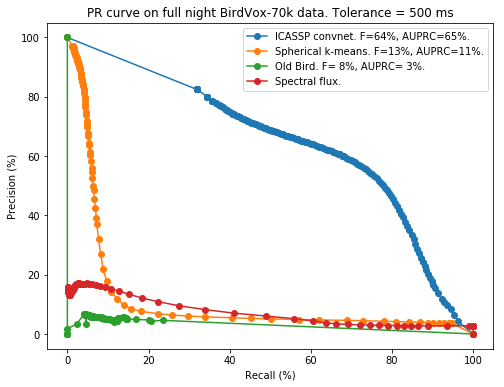

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(8, 6))


icassp_precisions = np.insert(icassp_precisions, 0, 100.0)
icassp_precisions = np.append(icassp_precisions, 0.0)
icassp_recalls = np.insert(icassp_recalls, 0, 0.0)
icassp_recalls = np.append(icassp_recalls, 100.0)
icassp_f1_score = np.max(icassp_f1_scores)
icassp_auprc = np.trapz(icassp_precisions, icassp_recalls) / 100
icassp_label = "ICASSP convnet, augmented. F={:2.0f}%, AUPRC={:2.0f}%.".format(
    icassp_f1_score, icassp_auprc)
plt.plot(icassp_recalls, icassp_precisions, "-o", label=icassp_label)


skm_precisions = np.insert(skm_precisions, 0, 100.0)
skm_precisions = np.append(skm_precisions, 0.0)
skm_recalls = np.insert(skm_recalls, 0, 0.0)
skm_recalls = np.append(skm_recalls, 100.0)
skm_f1_score = np.max(skm_f1_scores)
skm_auprc = np.trapz(skm_precisions, skm_recalls) / 100
skm_label = "SKM (out of set). F={:2.0f}%, AUPRC={:2.0f}%.".format(
    skm_f1_score, skm_auprc)
plt.plot(skm_recalls, skm_precisions, "-o", label=skm_label)


oldbird_precisions = np.insert(oldbird_precisions, 0, 100.0)
oldbird_precisions = np.append(oldbird_precisions, 0.0)
oldbird_recalls = np.insert(oldbird_recalls, 0, 0.0)
oldbird_recalls = np.append(oldbird_recalls, 100.0)
oldbird_f1_score = np.max(oldbird_f1_scores)
oldbird_auprc = np.trapz(oldbird_precisions, oldbird_recalls) / 100
oldbird_label = "Old Bird. F={:2.0f}%, AUPRC={:2.0f}%.".format(
    oldbird_f1_score, oldbird_auprc)
plt.plot(oldbird_recalls, oldbird_precisions, "-o", label=oldbird_label)


sf_precisions = np.insert(sf_total_precisions, 0, 100.0)
sf_precisions = np.append(sf_total_precisions, 0.0)
sf_recalls = np.insert(sf_total_recalls, 0, 0.0)
sf_recalls = np.append(sf_total_recalls, 100.0)
sf_label = "Spectral flux."
plt.plot(sf_recalls, sf_precisions, "-o", label=sf_label)


plt.title("PR curve on full night BirdVox-70k data. Tolerance = {} ms".format(tolerance_ms))
plt.xlabel("Recall (%)")
plt.ylabel("Precision (%)")
plt.legend()